Number of row = 4434
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                 
─────────(Expectation(CVD|DIABP,CURSMOKE2,SYSBP3,DIABP2,DIABP3,SYSBP))
d[BPMEDS]                                                             
Estimand assumption 1, Unconfoundedness: If U→{BPMEDS} and U→CVD then P(CVD|BPMEDS,DIABP,CURSMOKE2,SYSBP3,DIABP2,DIABP3,SYSBP,U) = P(CVD|BPMEDS,DIABP,CURSMOKE2,SYSBP3,DIABP2,DIABP3,SYSBP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



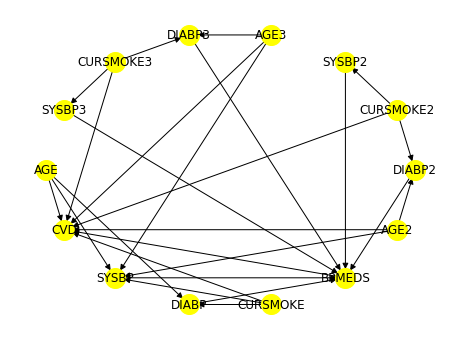

In [6]:
import numpy as np
import pandas as pd
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

# Read original data
df = pd.read_csv("../data/data_mice_frequency.csv")
# Get six columns we are interested in
# Convert float to int
df["BPMEDS"] = df["BPMEDS"].astype(int)
df['AGE'] = df['AGE'].astype(int)
df['SYSBP'] = df['SYSBP'].astype(int)
df['DIABP'] = df['DIABP'].astype(int)
df['CURSMOKE'] = df['CURSMOKE'].astype(int)
print("Number of row =", len(df))
# Create a model with our DAG and dataset.
model = CausalModel(
    data=df,
    treatment='BPMEDS',
    outcome='CVD',
    graph="digraph {AGE -> CVD;AGE -> SYSBP;AGE -> DIABP;CURSMOKE->CVD;CURSMOKE->DIABP;CURSMOKE->SYSBP;SYSBP->BPMEDS;DIABP->BPMEDS;BPMEDS->CVD;"
          "AGE2 -> CVD;AGE2 -> SYSBP;AGE2 -> DIABP2;CURSMOKE2->CVD;CURSMOKE2->DIABP2;CURSMOKE2->SYSBP2;SYSBP2->BPMEDS;DIABP2->BPMEDS;"
          "AGE3 -> CVD;AGE3 -> SYSBP;AGE3 -> DIABP3;CURSMOKE3->CVD;CURSMOKE3->DIABP3;CURSMOKE3->SYSBP3;SYSBP3->BPMEDS;DIABP3->BPMEDS}"
)
model.view_model()
# Figure out which estimators to using Dowhy
identified_estimand = model.identify_effect()
print(identified_estimand)

In [7]:
# Q2.3 Calculate risk difference using Dowhy and print out model parameters
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
for i, v in enumerate(model.causal_estimator.model.params):
    if i == 0:
        print("Intercept =", "{:.3f}".format(v))
    else:
        print("Parameter %s =" % str(i), "{:.3f}".format(v))
# Q2.3 Q3.1 Calculate E(Y|A = 1) and E(Y|A = 0) and risk ratio, since estimate_effect only gives us risk difference
E1 = model.do(1, identified_estimand, method_name="backdoor.linear_regression")
E0 = model.do(0, identified_estimand, method_name="backdoor.linear_regression")
# Calculate 95% percent confidence interval
difference_bootstrap = model.causal_estimator.estimate_confidence_intervals(estimate.value, confidence_level=0.95,
                                                                            method="bootstrap")
print("E(Y|A = 1) =", "{:.3f}".format(E1))
print("E(Y|A = 0) =", "{:.3f}".format(E0))
print("Risk Ratio =", "{:.3f}".format(E1 / E0))
print("Risk Difference =", "{:.3f}".format(estimate.value))
print("95% risk difference confidence interval =", np.around(difference_bootstrap, 3))

# Q3.1 Since the dowhy built-in function uses risk difference, we have to manually calculate risk ratio confidence interval
estimators = []
for i in range(500):
    model = CausalModel(
        data=df.sample(df.shape[0], replace=True),
        treatment='BPMEDS',
        outcome='CVD',
        graph="digraph {AGE -> CVD;AGE -> SYSBP;AGE -> DIABP;CURSMOKE->CVD;CURSMOKE->DIABP;CURSMOKE->SYSBP;SYSBP->BPMEDS;DIABP->BPMEDS;BPMEDS->CVD;"
              "AGE2 -> CVD;AGE2 -> SYSBP;AGE2 -> DIABP2;CURSMOKE2->CVD;CURSMOKE2->DIABP2;CURSMOKE2->SYSBP2;SYSBP2->BPMEDS;DIABP2->BPMEDS;"
              "AGE3 -> CVD;AGE3 -> SYSBP;AGE3 -> DIABP3;CURSMOKE3->CVD;CURSMOKE3->DIABP3;CURSMOKE3->SYSBP3;SYSBP3->BPMEDS;DIABP3->BPMEDS}")
    # For each iteration, calculate E(Y|A = 1) and E(Y|A = 0) and risk ratio as we did above
    E1 = model.do(1, identified_estimand, method_name="backdoor.linear_regression")
    E0 = model.do(0, identified_estimand, method_name="backdoor.linear_regression")
    estimators.append(E1 / E0)
estimators = np.array(estimators)
ci = [np.percentile(estimators, 2.5, axis=0), np.percentile(estimators, 97.5, axis=0)]
print("95% risk ratio confidence interval =", np.around(np.asarray(ci), 3))


Intercept = -0.427
Parameter 1 = 0.084
Parameter 2 = 0.001
Parameter 3 = 0.035
Parameter 4 = 0.001
Parameter 5 = 0.002
Parameter 6 = -0.003
Parameter 7 = 0.004
E(Y|A = 1) = 0.342
E(Y|A = 0) = 0.258
Risk Ratio = 1.326
Risk Difference = 0.084
95% risk difference confidence interval = [0.001 0.144]
95% risk ratio confidence interval = [0.976 1.68 ]
